In [2]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [3]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=7a1f7dfaf5ba21081b7eaafb58fb080ef0d6a6c1a925d11e97522475db8bf3c0
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Opening datasets

In [4]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 1.55 s


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [5]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(frac=1, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 38.1 ms


In [6]:
# so neste caso q n vamos usar transportation
#df = df.loc[df['scene_label'] != 'transportation']

time: 748 µs


In [7]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(5760, 3)
(4320, 3)
(4320, 3)
time: 10.3 ms


Reading the datasets and storing it to 'signals'

In [8]:
info_sound = df[['filename','scene_label']].to_numpy()

time: 3.49 ms


In [9]:
LABELS = ['indoor', 'outdoor', 'transportation']

time: 1.17 ms


In [10]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'

time: 797 µs


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



In [11]:
def clear_csv(FILEPATH):
    if os.path.exists(FILEPATH):
        # clear the file
        f = open(FILEPATH, "w")
        f.truncate()
        f.close()

time: 1.91 ms


# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [12]:
PARTS = 10
def get_features(signal, label, music_id)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(y, sr):
        return librosa.feature.spectral_centroid(y=y, sr=sr)
    def get_flatness(y):
        return librosa.feature.spectral_flatness(y=y)
    def get_rms(y):
        return librosa.feature.rms(y=y)
    def get_mfccs(y, sr):
        return librosa.feature.mfcc(y=y, sr=sr)

    feats = (np.zeros((1,47))[0])
    
    music_features = []
    signal = signal[:,0]
    for second in np.array_split(signal, PARTS):
        arr_mfcc = []
        #print(second.shape)
        c = get_centroid(second, SAMPLERATE)
        f = get_flatness(second)
        r = get_rms(second)
        mfccs = get_mfccs(second, SAMPLERATE)
        #print(np.array(mfccs).shape)
        mfccs = [[np.mean(x), np.std(x)] for x in mfccs]
        mfccs = np.array(mfccs).reshape(1,-1)[0]
        #print(mfccs.shape)
        mfccs = np.array_split(mfccs, mfccs.shape[0])
        #print(np.array(mfccs).shape)
        [arr_mfcc.append(x[0]) for x in mfccs]
        music_features = np.hstack([arr_mfcc, np.array([np.mean(c),np.std(c),np.mean(f), np.std(f),r[0][0], label, music_id])]) 
        #print(np.array(music_features).shape)
        feats = np.vstack([feats, music_features])  
            
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)

time: 22.6 ms


In [13]:
'''SAMPLERATE = 48000
clear_csv(FILEPATH)
music_id = 0
for filename, label in info_sound:
    music_id += 1
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))
        signal = signal - np.mean(signal)
        signal = signal / np.std(signal)
        feats = get_features(signal, LABELS.index(label), music_id)
        if (music_id == 1): 
            feats.to_csv(FILEPATH, mode='a', header=True, index=False)
        else:
            feats.to_csv(FILEPATH, mode='a', header=False, index=False)
'''

"SAMPLERATE = 48000\nclear_csv(FILEPATH)\nmusic_id = 0\nfor filename, label in info_sound:\n    music_id += 1\n    if(path.isfile(os.path.join(DIR_AUDIO, filename))):\n        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))\n        signal = signal - np.mean(signal)\n        signal = signal / np.std(signal)\n        feats = get_features(signal, LABELS.index(label), music_id)\n        if (music_id == 1): \n            feats.to_csv(FILEPATH, mode='a', header=True, index=False)\n        else:\n            feats.to_csv(FILEPATH, mode='a', header=False, index=False)\n"

time: 3.07 ms


In [221]:
# FIZ UMA REDUÇÃO
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'
PATH2 = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features_reduced.csv'
df = pd.read_csv(PATH2)

time: 1.25 s


In [182]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,-1.058339,21.557356,138.05847,14.475603,19.548351,7.791330,12.999234,9.100426,21.600418,9.719721,14.447177,5.627788,-2.575959,4.427872,18.317266,6.451638,10.959105,5.390676,-1.539624,6.407919,12.047143,4.549982,5.993327,4.566259,-0.212231,4.507074,8.500896,3.945682,2.442563,4.589476,4.401461,4.109094,3.373851,4.082730,11.001641,3.895880,-1.535144,4.202840,6.301800,3.566015,2786.5007,590.77673,0.001828,0.001382,0.813294,0,1
1,4.396373,21.423197,148.47241,15.754003,11.277305,9.872526,14.373900,7.776297,18.653526,7.554829,14.697559,5.129134,-6.335751,3.800787,14.953893,5.399337,4.685978,5.803996,-1.906804,5.615131,8.910424,4.739264,7.499866,4.471133,-0.237318,4.829782,8.624371,5.136345,2.421678,4.173443,5.396713,4.762895,4.861248,4.534096,9.062895,4.334170,-0.178703,4.084477,4.844233,3.843358,2555.3958,621.96936,0.002324,0.002302,0.684736,0,1
2,4.039622,17.797888,144.21483,17.299505,13.237467,10.163706,15.597115,8.671988,19.921995,7.423457,13.089581,6.040814,-7.515615,5.406296,18.674110,5.412951,6.736072,5.542896,-1.387348,4.790850,7.602405,5.642788,6.957246,5.658208,1.752044,4.009927,9.399924,4.410964,1.891177,4.591253,4.972094,3.710776,5.068874,4.100614,10.316883,4.004157,-0.827074,4.968072,4.236340,3.949600,2636.4204,608.40326,0.002042,0.001426,0.635067,0,1
3,-2.971225,10.324732,136.45264,18.312479,14.551553,11.336503,22.049950,8.914151,22.695292,8.642087,15.597689,7.342446,-4.216103,4.297370,15.508611,6.215239,8.329009,5.826522,0.360900,4.906341,5.219678,3.892498,5.428922,4.253340,-0.139352,5.321892,6.066510,5.048954,1.498638,5.300146,4.920936,4.376864,3.972958,3.853206,9.161014,3.760955,0.987634,3.306040,6.310652,4.094116,2856.5603,680.52310,0.002604,0.002187,1.075849,0,1
4,5.139622,14.154994,134.69928,16.620556,10.759510,10.910083,23.602348,11.977859,23.361319,11.256820,12.558866,6.413006,-5.102273,5.260015,14.652709,5.483495,8.625391,5.006371,-3.409853,6.349032,4.758740,4.915403,5.702315,4.877898,-1.291014,3.864297,7.296906,4.181767,4.482390,4.547701,1.890542,5.516852,4.352310,4.544364,8.832763,4.427038,-1.444807,4.540398,3.481488,5.612529,2981.6785,588.44150,0.003398,0.002189,0.628136,0,1


time: 91.8 ms


Reduzi para as features mais importantes (tirei stds)

In [218]:
#reduced_df = df
reduced_df = reduce_features(df)
reduced_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-1.058339,138.05847,19.548351,12.999234,21.600418,14.447177,-2.575959,18.317266,10.959105,-1.539624,12.047143,5.993327,-0.212231,8.500896,2.442563,4.401461,3.373851,11.001641,-1.535144,6.301800,2786.5007,590.77673,0.001828,0.001382,0.813294,0,1
1,4.396373,148.47241,11.277305,14.373900,18.653526,14.697559,-6.335751,14.953893,4.685978,-1.906804,8.910424,7.499866,-0.237318,8.624371,2.421678,5.396713,4.861248,9.062895,-0.178703,4.844233,2555.3958,621.96936,0.002324,0.002302,0.684736,0,1
2,4.039622,144.21483,13.237467,15.597115,19.921995,13.089581,-7.515615,18.674110,6.736072,-1.387348,7.602405,6.957246,1.752044,9.399924,1.891177,4.972094,5.068874,10.316883,-0.827074,4.236340,2636.4204,608.40326,0.002042,0.001426,0.635067,0,1
3,-2.971225,136.45264,14.551553,22.049950,22.695292,15.597689,-4.216103,15.508611,8.329009,0.360900,5.219678,5.428922,-0.139352,6.066510,1.498638,4.920936,3.972958,9.161014,0.987634,6.310652,2856.5603,680.52310,0.002604,0.002187,1.075849,0,1
4,5.139622,134.69928,10.759510,23.602348,23.361319,12.558866,-5.102273,14.652709,8.625391,-3.409853,4.758740,5.702315,-1.291014,7.296906,4.482390,1.890542,4.352310,8.832763,-1.444807,3.481488,2981.6785,588.44150,0.003398,0.002189,0.628136,0,1


time: 71.4 ms


DF: Descrição

    features
*   0-19: MFCSS (media)
*   20: média centroide 
*   21: std centroide
*   22: media flatness
*   23: std flatness
*   24: rms

        outros
*   25: LABEL
*   26: Music_id






In [183]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns

time: 2.77 ms


Split no dataframe baseado em grupos do número da música

In [198]:
def split_by_music_id(df):
    last_col = len(df.columns) - 1
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 2).split(df, groups=df.iloc[:,last_col].values))
    return [train_inds, test_inds]

time: 2.66 ms


Split no dataframe selecionado, em teste e treino

In [227]:
def split_train_test(df,train_inds, test_inds):
    X_train = (df.iloc[train_inds, 0:-2])
    X_test = (df.iloc[test_inds,0:-2])
    y_train = (df.iloc[train_inds,[-2,-1]]).values
    y_test = (df.iloc[test_inds,[-2,-1]]).values
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return [X_train, X_test, y_train, y_test]

time: 3.01 ms


In [186]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 3.38 ms


# Random Forest Classifier

In [187]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

time: 1.17 ms


In [189]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
#from joblib import dump, load
from sklearn.externals import joblib

time: 2.89 ms


In [229]:
def best_estimator(X_train, y_train,X_test, y_test):
    n_estimators = [100, 300, 500, 800, 1000]
    acc = 0
    model = RandomForestClassifier()
    y_pred_final = []
    estimator = 0
    for k in n_estimators:
        clf = RandomForestClassifier(random_state=42, n_estimators=k)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        if (metrics.accuracy_score(y_test, y_pred) > acc):
            acc =  metrics.accuracy_score(y_test, y_pred)
            model = clf
            y_pred_final = y_pred
            estimator = k
    return model, y_pred, acc, estimator

def plot_feature_importances(feature_imp, num_feats):
    print(num_feats)
    plt.figure(figsize=(15,10))
    y = [round(num, 3) for num in feature_imp]
    sns.barplot(x=np.arange(0,num_feats - 2), y=y)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.xticks(np.arange(0,num_feats - 2))
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()

def get_model_random_forest(X_train,y_train, y_test, X_test, num_feats):
    
    #Create a Gaussian Classifier
    clf = RandomForestClassifier(random_state=42, n_estimators=3, max_depth=50)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    # open a file, where you ant to store the data
    filename = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/rforest_3_50.pkl'
    # dump information to that file
    #dump(clf, filename) 
    #with open(filename, 'wb') as f:
    #    pickle.dump(clf, f)
    joblib.dump(clf, filename,compress=9)
    print("Accuracy Sem Votação:",metrics.accuracy_score(y_test, y_pred))
    #print([{id_feat:feature_importance} for id_feat, feature_importance in enumerate(clf.feature_importances_)])
    plot_feature_importances(clf.feature_importances_, num_feats)
    return clf, y_pred
    '''
    clf = LinearSVC(random_state=42, C=100)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    file = open('/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/model.pickle', 'wb')
    # dump information to that file
    pickle.dump(clf, file)
    # close the file
    file.close()
    return clf, y_pred
    '''


time: 41.2 ms


Contagem das predições para cada música

In [191]:
def contagem_predicoes(y_test, y_pred):
    counts = dict()
    for id in np.unique(y_test[:,1]):
        counts[id] = []
    #print(counts)
    for t, p in zip(y_test, y_pred):
        counts[t[1]].append(p)
    counter = [Counter(y) for x,y in counts.items()]
    return counter

def acc_votacao(counter, y_test):
    #print(np.unique(y_test[1]))
    #print(counter, y_test)
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    #music_y_test = [[x,y] for x,y in y_test]
    #music_y_test = np.unique(music_y_test, axis=0)[:,0]
    music_y_test = np.unique(y_test, axis=0)[:,0]
    #print(music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 9.41 ms


In [192]:
def pca(X_test, y_test):
    pca = PCA(3)
    trans_pca = pca.fit_transform(X_test)
    trans_pca = pd.DataFrame(trans_pca)
    trans_pca['Labels'] = y_test[:,0]
    trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
    print(pca.explained_variance_)
    trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

time: 5.65 ms


In [193]:
def reduce_features(df):
    cols= df.columns
    #print(cols)
    without_std = [x for i, x in enumerate(cols[:40]) if (i % 2) == 0]
    cols = [*without_std, *cols[40:47]] 
    newdf = df[cols]
    #print(len(cols))
    new_cols = np.arange(len(cols))
    newdf.rename(columns=dict(zip(newdf.columns,new_cols)), inplace=True)
    return newdf


time: 5.96 ms


In [226]:
def classify(reduced_df):
    train_inds, test_inds = split_by_music_id(reduced_df)
    X_train, X_test, y_train, y_test = split_train_test(reduced_df,train_inds, test_inds) 
    X_train, X_test = standardize(X_train, X_test)
    num_feats = len(reduced_df.columns)
    rf_model, y_pred = get_model_random_forest(X_train,y_train[:,0], y_test[:,0], X_test, num_feats)
    contagens = contagem_predicoes(y_test, y_pred)
    final_accuracy = acc_votacao(contagens, y_test)
    pca(X_test, y_test)
    return final_accuracy

time: 4.87 ms


No handles with labels found to put in legend.


Accuracy Sem Votação: 0.7788555194805195
27


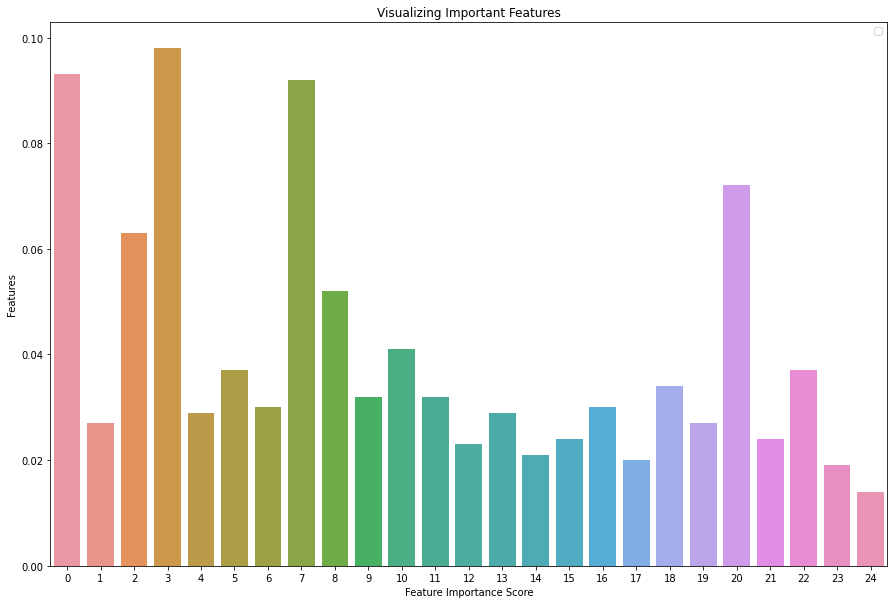

[5.8024419  2.92797329 1.67688531]
0.8762175324675324


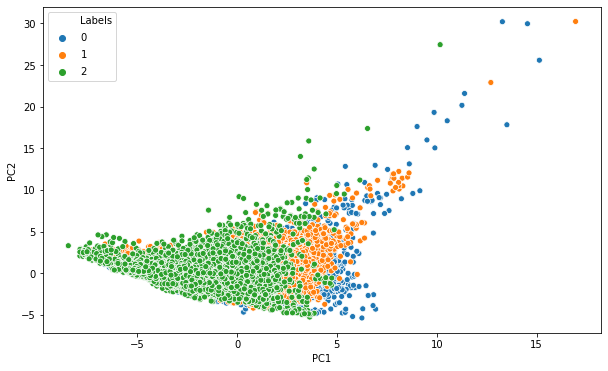

time: 6.48 s


In [230]:
acc = classify(reduced_df)
print(acc)

Tamanho do modelo em KB

In [234]:
(os.path.getsize(BASE_PATH + 'rforest_3_50.pkl')/1024)

764.2919921875

time: 3.05 ms
